In [119]:
import numpy as np
import random
import cvxpy as cp
import scipy.linalg as lin
import scipy.sparse as sparse
from sklearn.preprocessing import normalize, minmax_scale
import matplotlib.pyplot as plt 
import seaborn as sns
sns.set()

In [120]:
#dimensions
n = 2**6
m = 2**5

#random matrix
def random_matrix(m,n):
    A1 = np.random.normal(0,1,(m,n))
    A1_norm = normalize(A1, axis=0, norm='max')
    A_random = A1_norm
    return(A_random)
A_random = random_matrix(m,n)

#fourier matrix
def fourier_matrix(m,n):
    A2 = lin.dft(n).real
    A2_norm = normalize(A2, axis=0, norm='max')
    ind = np.random.choice(np.arange(len(A2_norm)),m)
    A_fourier = A2_norm[ind,:]
    return(A_fourier)
A_fourier = fourier_matrix(m,n)

#sparse vector
def sparse_vector(m,n):
    sparse_array = np.zeros([m,n])
    s_vals = np.linspace(0,0.5,m)
    for s in s_vals:
        sparse_rand = sparse.rand(1,n,s).toarray()
        sparse_array = np.append(sparse_array,sparse_rand,axis=0)
    sparse_array = sparse_array[m+1:]
    return(sparse_array)
sparse_array = sparse_vector(m,n)

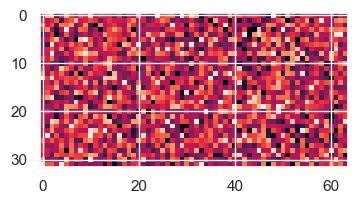

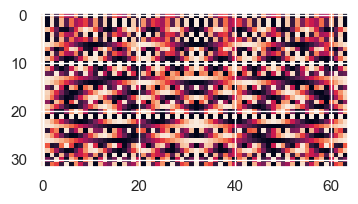

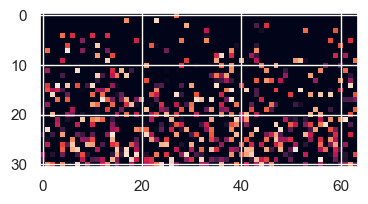

In [121]:
plt.figure(figsize=(5,2))
plt.imshow(A_random)
plt.show()
plt.figure(figsize=(5,2))
plt.imshow(A_fourier)
plt.show()
plt.figure(figsize=(5,2))
plt.imshow(sparse_array)
plt.show()

In [122]:
# 2-Norm
def norm2(x):
    return np.linalg.norm(x,2)

# Normalized Error
def normalized_error(x,x_pre):
    return norm2(x-x_pre)/norm2(x)

# Average Over n Elements
def avg_n(x,num):
    return(np.average(np.array(x).reshape(-1,num), axis=1))

# Hard Thresholding Function
def hard_thresh(x,s):
    S = np.argsort(abs(x),axis=0)[::-1][:s]
    xT = np.zeros_like(x)
    xT[S] = x[S]
    return xT, S

In [123]:
# L1 Minimization
def L1min(A,x):
    b = A.dot(x)
    r = b
    x_pre = np.zeros(n)
    count = 0
    while norm2(r)>thresh and count<m:
        x_pre = cp.Variable(n)
        prob = cp.Problem(cp.Minimize(cp.norm(x_pre,1)),[A@x_pre == b])
        x_pre = prob.solve()
        count+=1
    error = normalized_error(x,x_pre)
    return(error)

# Orthogonal Matching Pursuit
def OMP(A,x):  
    b = A.dot(x)
    r = b
    x_pre = np.zeros(n)
    S = []
    count = 0
    while norm2(r)>thresh and count<m:
        j = np.argmax(abs(A.T.dot(r)))
        S.append(j)
        X = A[:,S]
        x_pre[S] = np.linalg.pinv(np.dot(X.T,X)).dot(X.T).dot(b)
        r = b - A.dot(x_pre)
        count+=1
    error = normalized_error(x,x_pre)
    return(error)

# Matching Pursuit
def MP(A,x):
    b = A.dot(x)
    r = b
    x_pre = np.zeros(n)
    count = 0
    while norm2(r)>thresh and count<m:
        j = np.argmax(abs(A.T.dot(r)))
        t = A[:,j].T.dot(r)
        x_pre[j] = x_pre[j] + t
        r = r - A[:,j].dot(t)
        count += 1
    error = normalized_error(x,x_pre)
    return(error)

# Iterative Hard Threshold
def IHT(A,x):
    b = A.dot(x)
    r = b
    s = np.count_nonzero(x)
    x_pre = np.zeros(n)
    count = 0
    while norm2(r)>thresh and count<m:
        j = x_pre + A.T.dot(r)
        x_pre = hard_thresh(j,s)[0]
        r = b - A.dot(x_pre)
        count += 1
    error = normalized_error(x,x_pre)
    return(error)

# Compressive Sampling Matching Pursuit
def COSAMP(A,x):
    b = A.dot(x)
    r = b
    s = np.count_nonzero(x)
    x_pre = np.zeros(n)
    x_new = np.zeros(n)
    count = 0
    while norm2(r)>thresh and count<m:
        j = A.T.dot(r)
        ht = hard_thresh(j,2*s)[1]
        X = A[:,ht]
        x_pre[ht] = np.linalg.pinv(np.dot(X.T,X)).dot(X.T).dot(b)
        ht2 = hard_thresh(x_pre,s)[1]
        x_new[ht2] = x_pre[ht2]
        r = b - A.dot(x_new)
        count += 1
    error = normalized_error(x,x_pre)
    return(error)

# Basic Thresholding
def BT(A,x):
    b = A.dot(x)
    r = b
    s = np.count_nonzero(x)
    x_pre = np.zeros(n)
    count = 0
    while norm2(r)>thresh and count<m:
        j = A.T.dot(b)
        ht = hard_thresh(j,s)[1]
        X = A[:,ht]
        x_pre[ht] = np.linalg.pinv(np.dot(X.T,X)).dot(X.T).dot(b)
        count += 1
    error = normalized_error(x,x_pre)
    return(error)

# Hard Thresholding Pursuit
def HTP(A,x):
    b = A.dot(x)
    r = b
    s = np.count_nonzero(x)
    x_pre = np.zeros(n)
    count = 0
    while norm2(r)>thresh and count<m:
        j = x_pre + A.T.dot(r)
        ht = hard_thresh(j,s)[1]
        X = A[:,ht]
        x_pre[ht] = np.linalg.pinv(np.dot(X.T,X)).dot(X.T).dot(b)
        r = b - A.dot(x_pre)
        count += 1
    error = normalized_error(x,x_pre)
    return(error)

# Subspace Pursuit
def SP(A,x):
    b = A.dot(x)
    r = b
    s = np.count_nonzero(x)
    x_pre = np.zeros(n)
    x_new = np.zeros(n)
    count = 0
    while norm2(r)>thresh and count<m:
        j = A.T.dot(r)
        ht = hard_thresh(j,2*s)[1]
        X = A[:,ht]
        x_pre[ht] = np.linalg.pinv(np.dot(X.T,X)).dot(X.T).dot(b)
        ht2 = hard_thresh(x_pre,s)[1]
        X2 = A[:,ht2]
        x_new[ht2] = np.linalg.pinv(np.dot(X2.T,X2)).dot(X2.T).dot(b)
        r = b - A.dot(x_new)
        count += 1
    error = normalized_error(x,x_pre)
    return(error)

In [124]:
thresh = 1e-6
num = 10
x_all = sparse_vector(m,n)

L1min_solution_r = []
OMP_solution_r = []
MP_solution_r = []
COSAMP_solution_r = []
IHT_solution_r = []
BT_solution_r = []
HTP_solution_r = []
SP_solution_r = []

L1min_solution_f = []
OMP_solution_f = []
MP_solution_f = []
COSAMP_solution_f = []
IHT_solution_f = []
BT_solution_f = []
HTP_solution_f = []
SP_solution_f = []

for i in x_all:
    print(np.count_nonzero(i))
    x = i
    for j in range(num):
        A_r = random_matrix(m,n)
        A_f = fourier_matrix(m,n)
        
        L1min_solution_r.append(L1min(A_r,x))
        OMP_solution_r.append(OMP(A_r,x))
        MP_solution_r.append(MP(A_r,x))
        IHT_solution_r.append(IHT(A_r,x))
        COSAMP_solution_r.append(COSAMP(A_r,x))
        BT_solution_r.append(BT(A_r,x))
        HTP_solution_r.append(HTP(A_r,x))
        SP_solution_r.append(SP(A_r,x))
        
        L1min_solution_f.append(L1min(A_f,x))
        OMP_solution_f.append(OMP(A_f,x))
        MP_solution_f.append(MP(A_f,x))
        IHT_solution_f.append(IHT(A_f,x))
        COSAMP_solution_f.append(COSAMP(A_f,x))
        BT_solution_f.append(BT(A_f,x))
        HTP_solution_f.append(HTP(A_f,x))
        SP_solution_f.append(SP(A_f,x))

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32


In [125]:
L1min_sol_r = minmax_scale(avg_n(L1min_solution_r,num))
OMP_sol_r = minmax_scale(avg_n(OMP_solution_r,num))
MP_sol_r = minmax_scale(avg_n(MP_solution_r,num))
COSAMP_sol_r = minmax_scale(avg_n(COSAMP_solution_r,num))
IHT_sol_r = minmax_scale(avg_n(IHT_solution_r,num))
BT_sol_r = minmax_scale(avg_n(BT_solution_r,num))
HTP_sol_r = minmax_scale(avg_n(HTP_solution_r,num))
SP_sol_r = minmax_scale(avg_n(SP_solution_r,num))

L1min_sol_f = minmax_scale(avg_n(L1min_solution_f,num))
OMP_sol_f = minmax_scale(avg_n(OMP_solution_f,num))
MP_sol_f = minmax_scale(avg_n(MP_solution_f,num))
COSAMP_sol_f = minmax_scale(avg_n(COSAMP_solution_f,num))
IHT_sol_f = minmax_scale(avg_n(IHT_solution_f,num))
BT_sol_f = minmax_scale(avg_n(BT_solution_f,num))
HTP_sol_f = minmax_scale(avg_n(HTP_solution_f,num))
SP_sol_f = minmax_scale(avg_n(SP_solution_f,num))

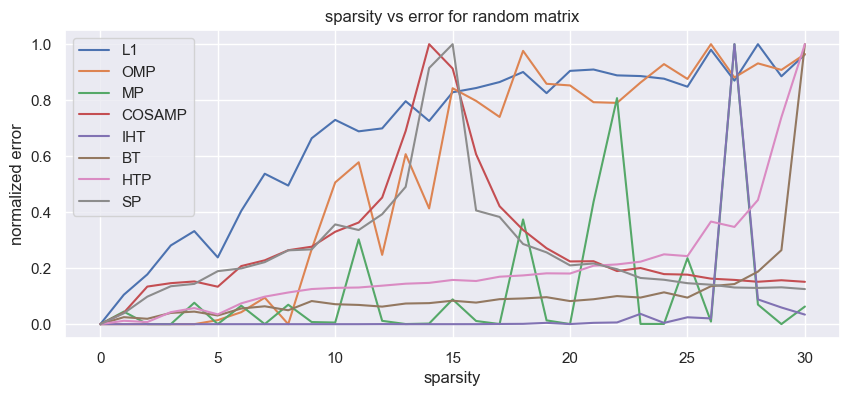

In [126]:
plt.figure(figsize=(10,4))
plt.plot(L1min_sol_r,label='L1')
plt.plot(OMP_sol_r,label='OMP')
plt.plot(MP_sol_r,label='MP')
plt.plot(COSAMP_sol_r,label='COSAMP')
plt.plot(IHT_sol_r,label='IHT')
plt.plot(BT_sol_r,label='BT')
plt.plot(HTP_sol_r,label='HTP')
plt.plot(SP_sol_r,label='SP')
plt.xlabel('sparsity')
plt.ylabel('normalized error')
plt.title('sparsity vs error for random matrix')
plt.legend()

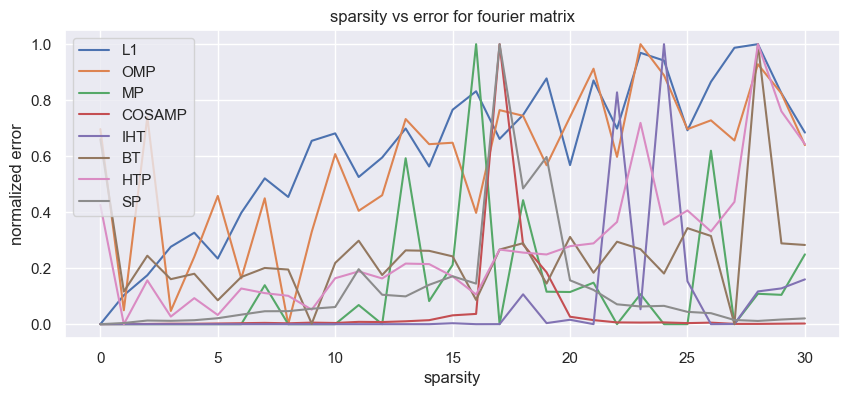

In [127]:
plt.figure(figsize=(10,4))
plt.plot(L1min_sol_f,label='L1')
plt.plot(OMP_sol_f,label='OMP')
plt.plot(MP_sol_f,label='MP')
plt.plot(COSAMP_sol_f,label='COSAMP')
plt.plot(IHT_sol_f,label='IHT')
plt.plot(BT_sol_f,label='BT')
plt.plot(HTP_sol_f,label='HTP')
plt.plot(SP_sol_f,label='SP')
plt.xlabel('sparsity')
plt.ylabel('normalized error')
plt.title('sparsity vs error for fourier matrix')
plt.legend()